In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

%matplotlib inline

from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from numba import jit

@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

@jit
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    return 'MCC', best_mcc

In [45]:
dtrain = xgb.DMatrix('input_hdf/train_with_faron.buffer')

In [3]:
dtrain.num_col()

2774

In [4]:
df1 = pd.read_csv('input_orig/train_numeric.csv', usecols=['Id','Response'])

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1, df1.Response.values, test_size=0.1, random_state=42, stratify=df1.Response.values)

In [6]:
y = dtrain.get_label()
prior = np.sum(y) / (1.*len(y))

In [7]:
dvalid = dtrain.slice(X_test.index)

In [8]:
dvalid.num_row(), X_test.shape

(118375, (118375, 2))

In [9]:
dtrain = dtrain.slice(X_train.index)

In [10]:
dtrain.num_row(), X_train.shape

(1065372, (1065372, 2))

In [11]:
#spw = (y.shape[0]-y.sum())/y.sum()

In [26]:
xgb_params1 = {
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'subsample': 1,
    'learning_rate': 0.15,
    'max_depth': 15,
    'min_child_weight': 1,
    'gamma': 0, 
    'max_delta_step': 1,
    'base_score': prior,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'silent': 0,
    'seed': 12,
    'nthread': 16
}
#'tree_method': 'exact',
evals  = [(dtrain,'train'), (dvalid,'eval')]
bst1 = xgb.train(xgb_params1, dtrain, num_boost_round=500, 
          evals=evals, early_stopping_rounds=20, 
          verbose_eval=1, feval=mcc_eval, maximize=True)

[0]	train-MCC:0.224465	eval-MCC:0.212381
Multiple eval metrics have been passed: 'eval-MCC' will be used for early stopping.

Will train until eval-MCC hasn't improved in 20 rounds.
[1]	train-MCC:0.234591	eval-MCC:0.222568
[2]	train-MCC:0.239831	eval-MCC:0.225888
[3]	train-MCC:0.242801	eval-MCC:0.229293
[4]	train-MCC:0.24494	eval-MCC:0.230438
[5]	train-MCC:0.247138	eval-MCC:0.230853
[6]	train-MCC:0.248845	eval-MCC:0.232395
[7]	train-MCC:0.253032	eval-MCC:0.234811
[8]	train-MCC:0.256231	eval-MCC:0.233854
[9]	train-MCC:0.258953	eval-MCC:0.235166
[10]	train-MCC:0.2739	eval-MCC:0.238376
[11]	train-MCC:0.298027	eval-MCC:0.241546
[12]	train-MCC:0.328841	eval-MCC:0.244269
[13]	train-MCC:0.356351	eval-MCC:0.246568
[14]	train-MCC:0.396924	eval-MCC:0.251956
[15]	train-MCC:0.436439	eval-MCC:0.261143
[16]	train-MCC:0.473435	eval-MCC:0.260632
[17]	train-MCC:0.51518	eval-MCC:0.26367
[18]	train-MCC:0.550943	eval-MCC:0.28526
[19]	train-MCC:0.564085	eval-MCC:0.322822
[20]	train-MCC:0.56197	eval-MCC:0.3

In [27]:
import operator
importance = bst1.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

In [29]:
len(importance)

761

In [30]:
bst1.save_model('435461.model')

In [34]:
pred_valid = bst1.predict(dvalid, ntree_limit=bst1.best_ntree_limit)

0.435461051629 0.4354610516292058


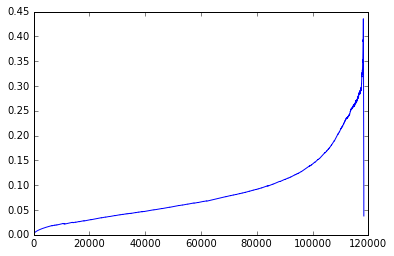

In [35]:
best_proba, best_mcc, y_pred = eval_mcc(dvalid.get_label(), pred_valid, show=True)

In [40]:
dtest = xgb.DMatrix('input_hdf/test_with_faron.buffer')

In [41]:
# generate predictions at the chosen threshold
preds = (bst1.predict(dtest, ntree_limit=bst1.best_ntree_limit) > best_proba).astype(np.int8)

In [44]:
# and submit
sub = pd.read_csv("input_orig/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("435461_submission.csv.gz", compression="gzip")